In [171]:
from nltk import pos_tag
import csv
import re
import numpy as np
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx
from copy import deepcopy
import pickle
from entity_groups import *
from graphviz import Source
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 
#from bert_serving.client import BertClient
from sklearn.preprocessing import normalize

from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('bert-base-nli-mean-tokens')
wnl = WordNetLemmatizer()
#corpus_embeddings = embedder.encode(corpus)

In [172]:
junk_rel = ["be","have","do","let","","make","tell","say","describe","decide","want","name","know","think","try","become","oneday","put","come",'see', 'need', 'look', 'help', 'come', 'take', 'get', 'put', 'pick', 'turn', 'go', 'stand', 'give', 'notice', 'use',"get","start","are"]

# hypothetical words that are generally useless / qualifiers
junk_words = ["would","could","should","maybe","perhaps","think","might","assume","claim","want","wish","must"]
# negative sentences
junk_words.extend(['n\'t',"not"])
print(junk_words)

# perspective actants that are pointless
junk = ["you","i","we","the","it","he","she","steinbeck","people","author",
        "book","me","steinback","him","her","their","this","","shelley","mary","harper","lee","tolkien","orwell"]

['would', 'could', 'should', 'maybe', 'perhaps', 'think', 'might', 'assume', 'claim', 'want', 'wish', 'must', "n't", 'not']


In [173]:
DATE = "0113"

# ########################## CHOOSE ONE #########################

#C = of_mice_and_men_C
# #C = the_hobbit_C
# #C = frankenstein_C
# #C = to_kill_a_mockingbird_C
# #

# C_use = {}
# for key in C:
#     for val in C[key]:
#         C_use[val] = key

########################## CHOOSE ONE #########################

#S = of_mice_and_men_S
#S = the_hobbit_S
#S = frankenstein_S
#S = to_kill_a_mockingbird_S
S = animal_farm_S

S_use = {}
for key in S:
    for val in S[key]:
        S_use[val] = key

########################## CHOOSE ONE #########################

#text = "of_mice_and_men"
#text = "the_hobbit"
#text = "frankenstein"
#text = "to_kill_a_mockingbird"
text = "animal_farm"

results_path = "Results" + DATE + "/" + text
adj_mat_path = "Precedence_Matrix/" + text
abs_adj_mat_path = "AbsPrecedence_Matrix/" + text
#dic_path = "Dictionary/" + text + ".pickle"
ner_file = "Extracted_Relationships/" + text + "/df_extractions_with_ner.csv"
fileName = ner_file

In [174]:
def hypothetical_sentence(sent):
    '''
    Removes sentences that have the hypothetical list of words in them. 
    Does not offer information about sequencing.
    '''
    for word in sent.split():
        for ground_word in junk_words:
            if ground_word in word:
                return True
    return False

In [175]:
trajectories = []
same_post = 0
traj = ["START"]
mapToFile = defaultdict(list)

with open(fileName) as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')

    for row in readCSV:
        sub_r = ""
        obj_r = ""
        sub_verb = ""

        if hypothetical_sentence(row[3]):
            continue

        try:
            sub = re.search(r"\{(\w+)\}", row[4]).group(1).lower()
            rel_head = wnl.lemmatize(re.search(r"\{(\w+)\}", row[5]).group(1).lower(), pos='v')
            rel = row[5].replace("{","").replace("}","").replace("<<","").replace(">>","").lower()
            obj = re.search(r"\{(\w+)\}", row[6]).group(1).lower()
            sub_total = row[4]
            obj_total = row[6]
        except:
            continue

        if "} 's" in sub_total:
            temp_str = sub_total + " "
            temp = re.search("} 's (.*) ", temp_str)
            try:
                sub = temp.group(1)
                if len(sub.split()) > 1:
                    sub = sub.split()[0]
            except:
                continue
        if "} 's" in obj_total:
            temp_str = obj_total + " "
            temp = re.search("} 's (.*) ", temp_str)
            try:
                obj = temp.group(1)
                if len(obj.split()) > 1:
                    obj = obj.split()[0]
            except:
                continue

        #words = row[3].split()
        #rel_words = []   
        
        if rel == None or obj == None or sub == None:
            continue
        
        if same_post == row[1]:
            pass
        else:
            same_post = row[1]
            traj.append("TERMINATE")
            trajectories.append(traj)
            traj = ["START"]

        try:
            sub_r = S_use[sub]
        except:
            sub_r = ""
        
        try:
            obj_r = S_use[obj]
        except:
            obj_r = ""

        sub_verb = ""

        if len(rel.split()) == 1:
            sub_verb = rel_head #lemmatized
        else:
            sub_verb = rel

        if sub_r == obj_r or sub_r in junk or obj_r in junk or rel_head in junk_rel or rel.split()[0] == "to": # can't start with to!
            continue

        traj.append(sub_verb)
        traj.append(sub_r + "_" + obj_r)

        if row[1] not in mapToFile[sub_verb + "_" + sub_r + "_" + obj_r]:
            mapToFile[sub_verb + "_" + sub_r + "_" + obj_r].append(row[1])
        #traj.append(sub_d + "_" + obj_d)

# if we missed out on last post
if traj != "START":
    traj.append("TERMINATE")
    trajectories.append(traj)

In [176]:
same_post

'2481'

Text(0.5, 1.0, 'Histogram of Sequence Length per Review')

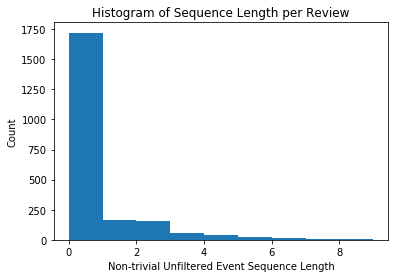

In [177]:
l = []
for traj in trajectories:
    l.append((len(traj)-2)/2)
plt.hist(l, bins = range(10))
plt.xlabel("Non-trivial Unfiltered Event Sequence Length")
plt.ylabel("Count")
plt.title("Histogram of Sequence Length per Review")

In [178]:
precedence_matrix = np.zeros((50000,50000))
dictionary_of_labels = {"START":0, "TERMINATE":1}
counter_of_labels = defaultdict(int)
max_rows = 1
max_cols = 1
counter = 2

for trajectory in trajectories:

    triplets = ["START"]
    index = 1

    while index < len(trajectory)-2:
        triplets.append(trajectory[index] + '_' + trajectory[index + 1])
        index += 2

    triplets.append("TERMINATE")

    for key,_ in enumerate(triplets[:-1]):
        if triplets[key] not in dictionary_of_labels:
            dictionary_of_labels[triplets[key]] = counter
            counter += 1
    
    triplet_temp = []

    for trip in triplets:
        if trip not in triplet_temp:
            triplet_temp.append(trip)

    triplets = triplet_temp

    for trip in triplets:
        counter_of_labels[trip] += 1

    alpha = 1.0

    for key in range(1,len(triplets)):
        key_hist = key-1

        while key_hist >= 0:
            max_cols = max(max_cols, dictionary_of_labels[triplets[key]])
            precedence_matrix[dictionary_of_labels[triplets[key_hist]]][dictionary_of_labels[triplets[key]]] += alpha
            alpha /= 1.0
            key_hist -= 1

precedence_matrix = precedence_matrix[:max_cols+1,:max_cols+1]

In [179]:
print(np.sum(precedence_matrix),np.max(precedence_matrix), precedence_matrix[0,1])
sumt = 0
for i in range(precedence_matrix.shape[0]):
    sumt += precedence_matrix[i][i]

first_big = 0
second_big = 0
save_row_col = [0,0]
for row in range(precedence_matrix.shape[0]):
    for col in range(precedence_matrix.shape[1]):
        if precedence_matrix[row,col] > first_big and row != 0 and col != 1:
            first_big = precedence_matrix[row,col]
            save_row_col = [row,col]

print(sumt, first_big, save_row_col)
# print(dictionary_of_labels)

7189.0 2207.0 2207.0
0.0 4.0 [53, 54]


In [180]:
import hdbscan
import os
import pandas as pd

path = "RC/" + text + "/"
try:
    os.makedirs(path)
except:
    pass

def cluster(key, phrases):
    # if phrases == []:
    #     return []
    
    # if len(phrases) == 1:
    #     return phrases
    corpus_embeddings = np.array(embedder.encode(phrases))
    
    # if corpus_embeddings.shape[0] == 0:
    #     return phrases

    clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples = 1)
    try:
        clusterer.fit(corpus_embeddings)
        labels = clusterer.labels_
    except:
        labels = [-1]

    label_scrape = np.unique(labels)

    storage = {}
    for i,label in enumerate(labels):
        if label not in storage:
            storage[label] = [phrases[i]]
        else:
            storage[label].append(phrases[i])


    save_dict = {"Label":[], "Phrases":[], "PostNum":[]}
    for label in storage:
        save_dict["Label"].append(label)
        save_dict["Phrases"].append(";".join(storage[label]))
        save_dict["PostNum"].append([mapToFile[i + "_" + key] for i in storage[label]])

    df = pd.DataFrame.from_dict(save_dict)
    df.to_csv(path + key + ".csv")

In [181]:
new_mat = deepcopy(precedence_matrix)
new_dict = defaultdict(list)
rel_map = defaultdict(list)
other_dict = dictionary_of_labels
diction = {}

for key in other_dict:
    diction[other_dict[key]] = key

for key in diction:
    if diction[key] not in ["START","TERMINATE"]:
        splits = diction[key].partition("_")
        new_dict[splits[2]].append(splits[0])

for key in new_dict:
    verbs = new_dict[key]
    verb_repeats = []
    for verb in verbs:
        for i in range(counter_of_labels[verb + "_" + key]):
            verb_repeats.append(verb)
    cluster(key, verb_repeats)

In [182]:
np.count_nonzero(new_mat)

4341

In [183]:
def reach(key):
    verbs = []
    labels = []
    df = pd.read_csv("RC_labeled/" + text + "/" + key + ".csv")
    for index, row in df.iterrows():
        new_phrases = row["Phrases"].split(";")
        verbs.extend(new_phrases)
        labels.extend([row["Tag"] for _ in new_phrases])
    return labels, verbs

In [184]:
for key in new_dict:
        try:
            labels, verbs = reach(key)
            for num in range(len(labels)):
                if labels[num] != "NADA":
                    rel_map[labels[num] + "_" + key].append(other_dict[verbs[num] + "_" + key])
        except:
            print("Reject:" + key)

print(rel_map)

counter_of_labels_t = defaultdict(int)
c = 2
A = np.zeros_like(new_mat)
new_index = {}

for key in rel_map:
    vals = list(set(rel_map[key]))
    vals.sort()

    for val in vals:
        counter_of_labels_t[key] += counter_of_labels[diction[val]]
        if key not in new_index:
            new_index[key] = c
            c += 1
        A[new_index[key]] = A[new_index[key]] + new_mat[val]


new_mat = np.transpose(new_mat)
A = np.transpose(A)

A_ = np.zeros_like(A)
for key in rel_map:
    vals = list(set(rel_map[key]))
    vals.sort()
    for val in vals:
        A_[new_index[key]] = A_[new_index[key]] + A[val]
        # if new_index[key] != val:
        #     A[val] = 0
            
A = np.transpose(A_)
new_mat = np.transpose(new_mat)

diction_final = {}
for key in new_index:
    diction_final[new_index[key]] = key
diction_final[0] = "START"
diction_final[1] = "TERMINATE"
A = A[:c, :c]

defaultdict(<class 'list'>, {'call_pigs_squealer': [2, 2, 2], 'overthrow_animals_jones': [3, 138, 14, 14, 14, 14, 102, 106, 107, 132, 146, 222, 274, 339, 382, 395, 402, 523, 546, 565, 615, 703, 728, 886, 889, 890, 14, 14, 14, 14, 34, 599, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 139, 139, 139, 139, 139, 206, 207, 316, 580, 396, 396, 396], 'fight_animals_jones': [89, 89, 89, 89, 133, 453, 453, 215, 253, 217, 217, 217, 217, 560, 576, 334, 668], 'introduce_pigs_commandments': [4, 616, 617, 95, 95], 'break_pigs_commandments': [5, 154, 327, 328, 627], 'change_pigs_commandments': [32, 32, 32, 179, 180, 180, 289, 416, 495, 511, 847, 494, 496], 'run_animals_farmhouse': [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 87, 87, 87, 94, 851, 903, 370, 850, 393, 423, 423, 423, 423], 'repel an attack on_animals_farmhouse': [11, 13], 'overtake_animals_farmhouse': [156, 156], 'create_animals_farmhouse': [184, 184, 184], 'live on_animals_farmhouse': [278, 278, 278], 'r

In [185]:
print(np.sum(A), np.max(A), np.min(A), c, A.shape[0], A.shape[1])
max_pos = (-1,-1)
maxim = -1
sumt = 0
for row in range(A.shape[0]):
    for col in range(A.shape[1]):
        if row == col:
            print(A[row,col])
            sumt += A[row,col]
        if maxim < A[row,col] and row != col:
            maxim = A[row,col]
            max_pos = (row,col)
print(max_pos, maxim)
print(sumt)
print(diction_final)

591.0 8.0 0.0 88 88 88
0.0
0.0
0.0
8.0
0.0
1.0
1.0
5.0
1.0
1.0
0.0
0.0
0.0
1.0
4.0
0.0
0.0
0.0
4.0
1.0
1.0
0.0
0.0
2.0
0.0
1.0
4.0
0.0
1.0
8.0
0.0
0.0
2.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
4.0
0.0
0.0
2.0
5.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
2.0
2.0
1.0
0.0
4.0
0.0
0.0
1.0
2.0
0.0
0.0
0.0
0.0
0.0
1.0
6.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
(47, 32) 5.0
96.0
{2: 'call_pigs_squealer', 3: 'overthrow_animals_jones', 4: 'fight_animals_jones', 5: 'introduce_pigs_commandments', 6: 'break_pigs_commandments', 7: 'change_pigs_commandments', 8: 'run_animals_farmhouse', 9: 'repel an attack on_animals_farmhouse', 10: 'overtake_animals_farmhouse', 11: 'create_animals_farmhouse', 12: 'live on_animals_farmhouse', 13: 'run snowball off_animals_farmhouse', 14: 'run humans off_animals_farmhouse', 15: 'change farmhouse name to_animals_farmhouse', 16: 'improve_animals_farmhouse', 17: 'overthrow_animals_farmhouse', 18: 'is chased off_jones_farmhouse', 19: 'owns_jones_farmhou

In [186]:
new_mat = deepcopy(A)
val_precedence_matrix = deepcopy(new_mat)

# all roads lead to terminate
for row in new_mat:
    row[1] = 1.0/1000.0

# all roads start from start
for i in range(len(new_mat[0])):
    if i >= 2:
        new_mat[0][i] = 1.0 / (len(new_mat[0])-2)

# normalize rows
for row in new_mat:
    sumt = sum(row)*1.0
    row /= sumt

# no self-loops
for i in range(new_mat.shape[0]):
    new_mat[i][i] = 0.0

In [187]:
mat = deepcopy(new_mat)
val_mat = deepcopy(val_precedence_matrix)

for row in range(val_mat.shape[0]):
    val_mat[row,row] = 0

singles = pair_wise_cycles = 0

# remove pair-wise cycles
for i in range(0, mat.shape[0]):
    for j in range(0, mat.shape[1]):

        if mat[i][j] > mat[j][i]:
            if mat[j][i] != 0:
                pair_wise_cycles += 1.0
                print(i,j,val_mat[j][i])
            mat[j][i] = 0

        elif mat[i][j] < mat[j][i]:
            if mat[i][j] != 0:
                pair_wise_cycles += 1.0
                print(i,j,val_mat[i][j])
            mat[i][j] = 0

        elif mat[i][j] == mat[j][i] and i != j and mat[j][i] != 0:
            mat[j][i] = 0
            pair_wise_cycles += 1.0
            print(i,j, val_mat[j][i])
            mat[i][j] = 0

3 5 1.0
3 8 1.0
3 14 2.0
7 29 1.0
8 18 1.0
8 56 1.0
14 29 4.0
15 52 1.0
18 22 1.0
18 38 1.0
19 51 1.0
19 56 1.0
22 61 1.0
29 77 4.0
37 60 1.0
42 60 1.0
44 86 2.0
47 66 2.0
51 56 1.0
63 64 2.0


In [188]:
np.sum(val_mat), np.sum(mat)

(495.0, 63.93153411349189)

In [189]:
mat_s = deepcopy(mat)
mat_s[mat_s > 0.0] = 1
mat_st = np.transpose(mat_s)

# remove singletons
for i in range(0, mat.shape[1]):
    # no branches from triplet for TERMINATE AND START
    if np.sum(mat_st[i]) == 1 and np.sum(mat_s[i]) == 1: 
        mat[i] = 0.0
        mat[0][i] = 0.0
        singles += 1.0

# we do not want to go from START -> TERMINATE directly.
mat[0][1] = 0.0
mat[1][1] = 0.0

In [190]:
np.sum(mat)

59.84622407469348

In [191]:
def compute_metric(from_node, to_node, mat):
    '''
    Adjust the metric to keep in check the approach of the graph.
    '''
    trust = mat[from_node][to_node]
    mat_t = np.transpose(mat)
    in_degree = np.sum(mat_t[to_node] > 0)
    out_degree = np.sum(mat[to_node] > 0)
    return 0.001*(out_degree + in_degree) + val_mat[from_node][to_node]


def not_cycle_from_to_node_to_from_node(from_node, to_node, mat_flow):
    '''
    Simple BFS: we do know that there are no cycles in here so
    no worries in computing a path from to to, to detemine cycle
    '''
    visited =[False]*mat_flow.shape[0] 
    #Create a queue for BFS 
    queue=[] 
    # Mark the source node as visited and enqueue it 
    queue.append(from_node) 
    visited[from_node] = True
    while queue: 
        #Dequeue a vertex from queue  
        n = queue.pop(0)      
        # If this adjacent node is the destination node, 
        # then return true 
        if n == to_node: 
            return False
        #  Else, continue to do BFS 
        to_nodes = np.argwhere(mat_flow[n] != 0)
        for i in to_nodes: 
            i = i[0]
            if visited[i] == False: 
                queue.append(i) 
                visited[i] = True
    # If BFS is complete without visited d 
    return True

In [192]:
mat[7,1]

0.00016663889351774703

In [193]:
number_of_steps = 100
current_time = 0
stack_per_time = [0]
cycles = 0
cycles_prob = []
cycles_real = 0
weight_of_discarded_edge = []
history_of_cycles = []
time_step = np.zeros_like(mat[0]) - 1.0
mat_flow = np.zeros_like(mat)

while current_time < number_of_steps:

    print(current_time)
    if stack_per_time == []:
        print("Max Time Limit: ", current_time)
        break
    
    new_stack = []
    for start_node in stack_per_time:
        metric = []
        to_nodes = np.argwhere(mat[start_node] != 0.0)
        for to_node in to_nodes:
            to_node = to_node[0]
            metric.append(compute_metric(start_node, to_node, mat))

        # what happens to those with no to-nodes like TERMINATE   
        try:
            n_metric = np.argsort(-1*np.array(metric))
            #threshold = metric[n_metric[0]] * 0.00005
            threshold = 0.0
        except:
            n_metric = []
            threshold = 0.0

        for i in range(len(n_metric)):
            if metric[n_metric[i]] > threshold:
                to_node_correct = to_nodes[n_metric[i]][0]
                cycles_real += 1
                if not_cycle_from_to_node_to_from_node(to_node_correct, start_node, mat_flow):
                    if to_node_correct not in new_stack:
                        new_stack.append(to_node_correct)
                    mat_flow[start_node][to_node_correct] = 1.0
                    time_step[to_node_correct] = current_time + 1.0
                    
                else:
                    cycles += 1
                    weight_of_discarded_edge.append(mat[start_node][to_node_correct])
                    history_of_cycles.append((start_node,to_node_correct))

    stack_per_time = new_stack
    print(stack_per_time)
    current_time += 1

print("Total ignored cycles: ", cycles, cycles_real)
print("Weights of Removed Edges: ", weight_of_discarded_edge)

0
[29, 63, 3, 74, 48, 65, 8, 47, 70, 56, 34, 86, 20, 64, 4, 35, 81, 68, 22, 44, 18, 60, 37, 26, 51, 19, 15, 76, 61, 46, 38, 6, 57, 41, 62, 43, 28, 75, 12, 14, 32, 78, 42, 67, 71, 87, 39, 36, 79, 23, 21, 13, 83, 7, 5, 72, 66, 82, 84, 45, 55, 40, 16, 24, 77, 33, 30, 50, 52, 54, 69, 49, 59, 27, 80, 10, 9, 85, 2]
1
[20, 28, 56, 48, 65, 26, 41, 75, 78, 47, 15, 61, 62, 21, 49, 1, 86, 44, 70, 34, 35, 81, 13, 36, 87, 59, 60, 37, 43, 4, 46, 6, 57, 12, 42, 63, 64, 32, 7, 66, 14, 84, 3, 74, 18, 79, 2, 71, 72, 19, 51, 22, 30, 76, 29, 39, 55, 23, 50, 38, 33, 40, 8, 27]
2
[28, 48, 70, 41, 62, 78, 64, 71, 72, 1, 86, 18, 26, 19, 51, 6, 75, 7, 44, 66, 34, 35, 81, 47, 63, 32, 42, 65, 21, 43, 60, 37, 36, 23, 39, 13, 74, 20, 22, 30, 50, 29, 56, 57, 87, 59, 40, 3, 4, 46, 12, 61, 84, 79, 55, 15, 49, 33, 14, 2]
3
[1, 7, 86, 44, 28, 66, 70, 34, 35, 81, 78, 71, 72, 43, 48, 63, 62, 19, 47, 61, 74, 20, 6, 42, 32, 84, 79, 40, 26, 13, 36, 87, 59, 60, 37, 64, 65, 51, 23, 39, 46, 33, 41, 29, 56, 18, 55, 75, 15, 21, 

In [194]:
sum(weight_of_discarded_edge)

81.80704970009403

In [195]:
for i in range(len(time_step)):
    for j in range(len(time_step)):
        if time_step[i] < time_step[j] and time_step[i] != -1 and time_step[j] != -1 and mat_flow[i][j] != 0:
            for k,source_node in enumerate(mat_flow[:][j]):
                if mat_flow[k][j] > 0 and k != i:
                    if not not_cycle_from_to_node_to_from_node(k,i, mat_flow):
                        mat_flow[k][j] = 0
                        print(k,j,val_mat[k][j])

8 1 0.0
10 1 0.0
82 1 0.0
5 1 0.0
9 1 0.0
14 1 0.0
38 1 0.0
67 1 0.0
0 4 0.0
67 4 1.0
0 6 0.0
5 6 1.0
8 6 1.0
0 12 0.0
0 26 0.0
5 26 2.0
0 34 0.0
8 34 1.0
38 34 1.0
67 34 1.0
0 41 0.0
0 42 0.0
0 43 0.0
0 46 0.0
0 47 0.0
8 47 1.0
0 57 0.0
5 57 1.0
0 60 0.0
0 70 0.0
3 1 0.0
54 1 0.0
0 13 0.0
0 18 0.0
8 18 1.0
38 18 1.0
0 20 0.0
8 20 1.0
0 22 0.0
0 30 0.0
54 30 1.0
0 37 0.0
3 60 2.0
0 63 0.0
0 74 0.0
8 74 1.0
0 3 0.0
4 1 0.0
12 1 0.0
13 1 0.0
15 1 0.0
16 1 0.0
18 1 0.0
20 1 0.0
21 1 0.0
22 1 0.0
23 1 0.0
24 1 0.0
26 1 0.0
29 1 0.0
37 1 0.0
45 1 0.0
46 1 0.0
47 1 0.0
52 1 0.0
55 1 0.0
56 1 0.0
57 1 0.0
63 1 0.0
64 1 0.0
65 1 0.0
68 1 0.0
74 1 0.0
76 1 0.0
77 1 0.0
83 1 0.0
41 1 0.0
48 1 0.0
66 1 0.0
0 2 0.0
0 14 0.0
0 56 0.0
82 56 1.0
0 79 0.0
0 84 0.0
0 8 0.0
3 26 2.0
0 29 0.0
14 29 2.0
38 29 2.0
8 56 2.0
3 57 1.0
4 37 1.0
63 37 1.0
4 60 1.0
45 60 1.0
63 60 1.0
8 3 1.0
67 3 2.0
0 75 0.0
38 75 1.0
0 21 0.0
29 21 1.0
3 47 2.0
22 47 2.0
29 47 1.0
0 65 0.0
29 65 2.0
0 23 0.0
4 20 1.0
29 20 4.

In [196]:
for i in range(0, mat_flow.shape[1]):
    # no branches from triplet for TERMINATE AND START
    if mat_flow[0][i] != 0 and mat_flow[i][1] != 0: 
        mat_flow[0][i] = 0.0
        mat_flow[i][1] = 0.0

In [197]:
print(mat_flow.shape)

(88, 88)


In [198]:
G = nx.from_numpy_matrix(mat_flow, create_using=nx.DiGraph)
DISP_THRESH = 2
bb = {}
for index, val in np.ndenumerate(val_mat):
    print(index, val)
    if val > 1:
        bb[index] = {"color":"red", "penwidth":2}
    else:
        bb[index] = {"color":"blue"}
nx.set_edge_attributes(G, bb)

bb1 = {}
for i in range(mat_flow.shape[0]):
    if (np.sum(mat_flow[i]) + np.sum(np.transpose(mat_flow)[i])) > DISP_THRESH:
        bb1[i] = {"color":"aquamarine", "penwidth":2}
    else:
        bb1[i] = {"color":"gold1"}
nx.set_node_attributes(G, bb1)
#nx.set_edge_attributes(G, "triangle", "target-arrow-shape")

2) 0.0
(70, 33) 0.0
(70, 34) 1.0
(70, 35) 1.0
(70, 36) 0.0
(70, 37) 0.0
(70, 38) 0.0
(70, 39) 0.0
(70, 40) 0.0
(70, 41) 0.0
(70, 42) 0.0
(70, 43) 1.0
(70, 44) 2.0
(70, 45) 0.0
(70, 46) 0.0
(70, 47) 0.0
(70, 48) 0.0
(70, 49) 0.0
(70, 50) 0.0
(70, 51) 0.0
(70, 52) 0.0
(70, 53) 0.0
(70, 54) 0.0
(70, 55) 0.0
(70, 56) 0.0
(70, 57) 0.0
(70, 58) 0.0
(70, 59) 0.0
(70, 60) 0.0
(70, 61) 0.0
(70, 62) 0.0
(70, 63) 0.0
(70, 64) 0.0
(70, 65) 0.0
(70, 66) 0.0
(70, 67) 0.0
(70, 68) 0.0
(70, 69) 0.0
(70, 70) 0.0
(70, 71) 2.0
(70, 72) 2.0
(70, 73) 0.0
(70, 74) 0.0
(70, 75) 0.0
(70, 76) 0.0
(70, 77) 0.0
(70, 78) 0.0
(70, 79) 0.0
(70, 80) 0.0
(70, 81) 1.0
(70, 82) 0.0
(70, 83) 0.0
(70, 84) 0.0
(70, 85) 0.0
(70, 86) 2.0
(70, 87) 0.0
(71, 0) 0.0
(71, 1) 0.0
(71, 2) 0.0
(71, 3) 0.0
(71, 4) 0.0
(71, 5) 0.0
(71, 6) 0.0
(71, 7) 0.0
(71, 8) 0.0
(71, 9) 0.0
(71, 10) 0.0
(71, 11) 0.0
(71, 12) 0.0
(71, 13) 0.0
(71, 14) 0.0
(71, 15) 0.0
(71, 16) 0.0
(71, 17) 0.0
(71, 18) 0.0
(71, 19) 0.0
(71, 20) 0.0
(71, 21) 0.0
(7

In [199]:
diction_swap = {}
for key in diction_final:
    try:
        words = diction_final[key].split("_")
        real_val = words[1] + "_" + words[0] + "_" + words[2]
    except:
        real_val = diction_final[key]
    diction_swap[key] = real_val

In [200]:
H = nx.relabel_nodes(G, diction_swap)
H.remove_nodes_from(list(nx.isolates(H)))
A_ = nx.nx_agraph.to_agraph(H)

for i in range(number_of_steps):
    same_priority = []
    for j in range(len(time_step)):
        if time_step[j] == i:
            same_priority.append(diction_swap[j])
    one = A_.add_subgraph(same_priority,rank='same')

A_.layout('dot')
A_.draw(results_path + '.png')
A_.write(text + '.dot')

In [201]:
diction_swap

{2: 'pigs_call_squealer',
 3: 'animals_overthrow_jones',
 4: 'animals_fight_jones',
 5: 'pigs_introduce_commandments',
 6: 'pigs_break_commandments',
 7: 'pigs_change_commandments',
 8: 'animals_run_farmhouse',
 9: 'animals_repel an attack on_farmhouse',
 10: 'animals_overtake_farmhouse',
 11: 'animals_create_farmhouse',
 12: 'animals_live on_farmhouse',
 13: 'animals_run snowball off_farmhouse',
 14: 'animals_run humans off_farmhouse',
 15: 'animals_change farmhouse name to_farmhouse',
 16: 'animals_improve_farmhouse',
 17: 'animals_overthrow_farmhouse',
 18: 'jones_is chased off_farmhouse',
 19: 'jones_owns_farmhouse',
 20: 'jones_retakes_farmhouse',
 21: 'jones_attacks_farmhouse',
 22: 'pigs_govern_animals',
 23: 'pigs_manipulate_animals',
 24: 'pigs_overthrow_jones',
 25: 'pigs_liberate manor farm from_jones',
 26: 'pigs_act like_humans',
 27: 'napoleon_leads_pigs',
 28: 'napoleon_executes_pigs',
 29: 'animals_overthrow_humans',
 30: 'animals_fight_humans',
 31: 'animals_believe_sq

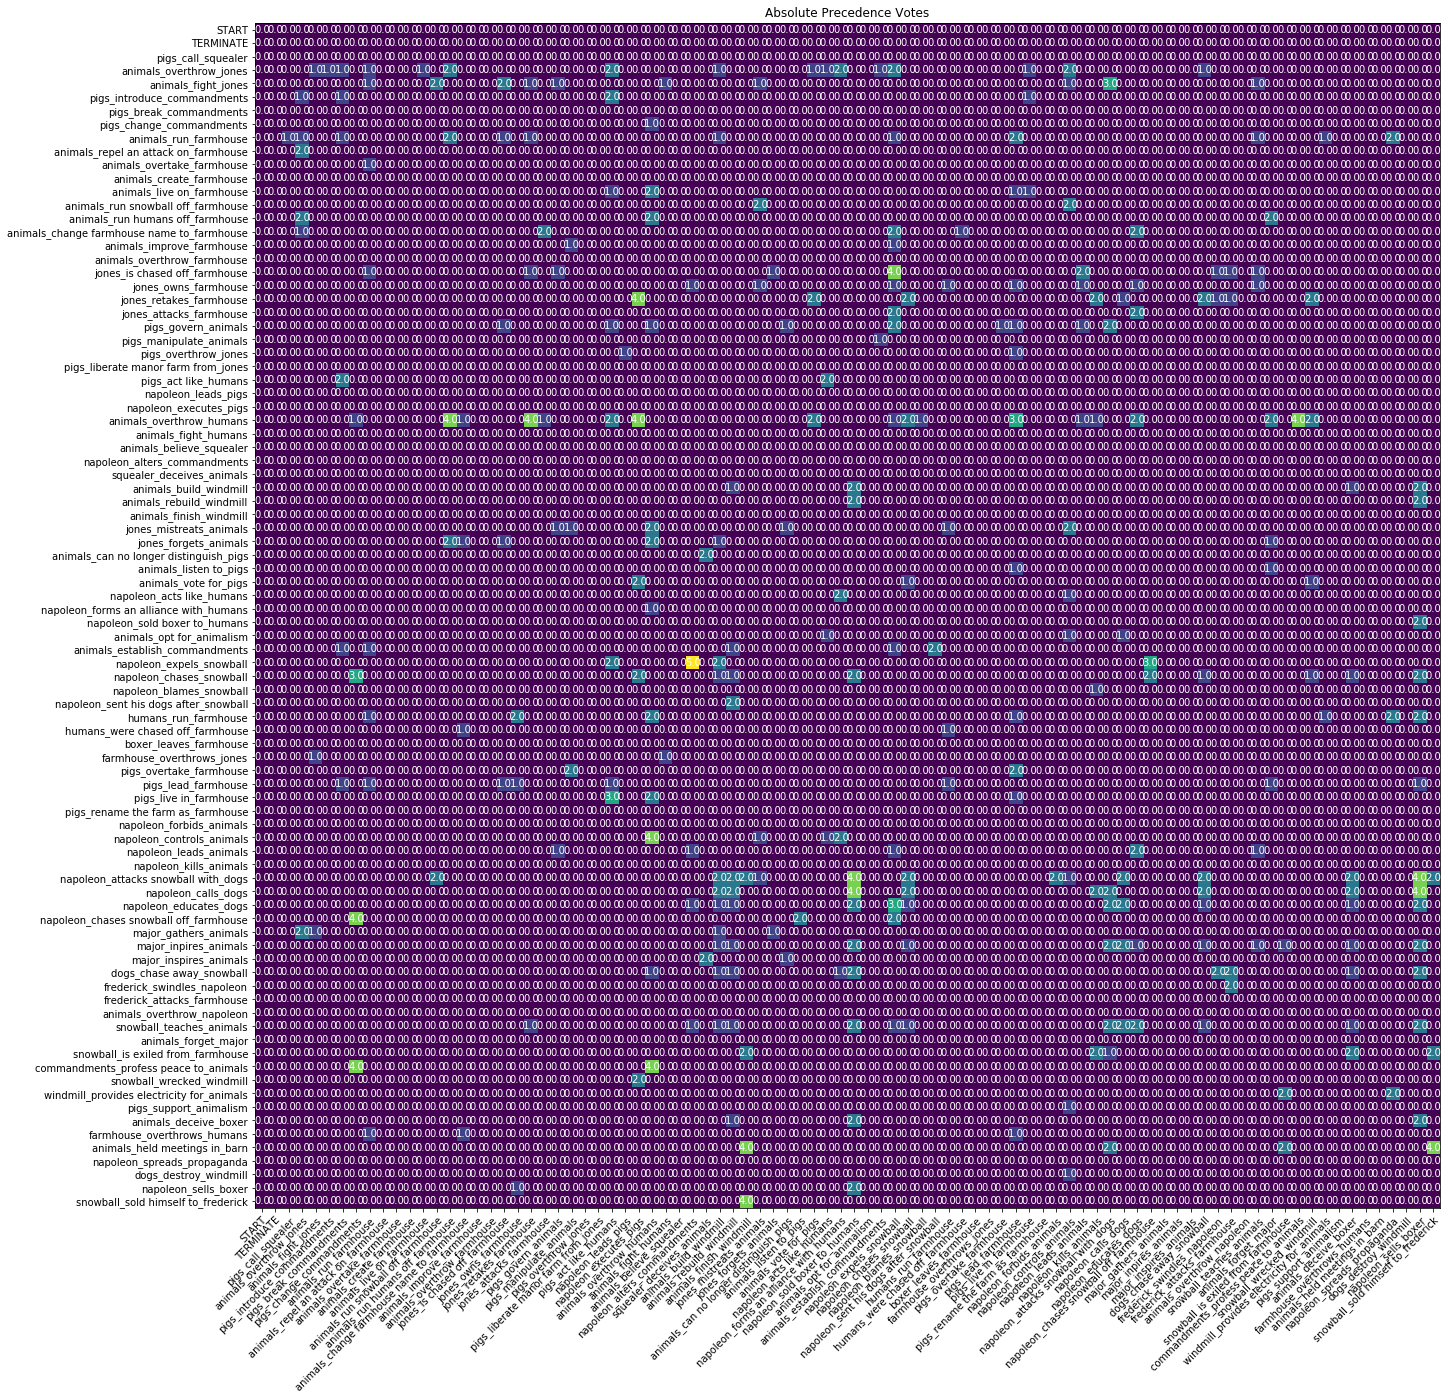

In [202]:
fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(val_mat)

# We want to show all ticks...
ax.set_xticks(np.arange(val_mat.shape[0]))
ax.set_yticks(np.arange(val_mat.shape[1]))
# ... and label them with the respective list entries


ax.set_xticklabels([diction_swap[i] for i in range(len(diction_swap.keys()))])
ax.set_yticklabels([diction_swap[i] for i in range(len(diction_swap.keys()))])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(val_mat.shape[0]):
    for j in range(val_mat.shape[1]):
        a = ax.text(j, i, val_mat[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Absolute Precedence Votes")
fig.tight_layout()
plt.show()

In [203]:
import os
evaluation = {"source":[], "target":[]}
for i in range(mat_flow.shape[0]):
    for j in range(mat_flow.shape[1]):
        if mat_flow[i,j] != 0:
            evaluation["source"].append(diction_swap[i])
            evaluation["target"].append(diction_swap[j])
df = pd.DataFrame.from_dict(evaluation)
df.to_csv("Empirical_Testing/" + text + ".csv")

In [204]:
text

'animal_farm'